<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Statistics With Baseball Data: Priors and Posteriors

---

Let’s review the general set up for Bayesian modeling. We have:

### $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)}{P(\;data\;)} P\left(\;model\;\right)$$

This is the diachronic interpretation of Bayes' theorem.

It can also be written as:

### $$posterior \propto likelihood \cdot prior$$

Here, the posterior is an update of our prior belief given the data observed.

## Bayesian Analysis of Batting Averages

---

Load in the simple batting average data for players below. There are just four fields in the data set: the player's name, their times at bat, their hits, and their batting average.

> *Note: [This section of the lab is a partial replication of this exercise in R, if you're interested](https://www.r-bloggers.com/understanding-empirical-bayes-estimation-using-baseball-statistics/). Here, we took out the empirical Bayes section because it's not technically a correct interpretation of Bayesian statistical analysis.*

In [53]:
import pandas as pd
import numpy as np
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
import altair as alt

alt.renderers.enable('notebook')
%matplotlib inline

data = pd.read_csv('./career_hits.csv')

In [59]:
data.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


### 1) Find the top and bottom three hitters according to their average.

What is wrong with using the average to find the three best and worst hitters?

In [60]:
data.sort_values('average', ascending = True).head(3)

,name,hits,at_bat,average
1494,Larry Ciaffone,0,5,0.0
7303,Jay Rogers,0,8,0.0
2552,Ferd Eunick,0,2,0.0


In [61]:
data.sort_values('average', ascending = False).head(3)

,name,hits,at_bat,average
5853,John Mohardt,1,1,1.0
9303,Al Wright,1,1,1.0
359,Jeff Banister,1,1,1.0


None of these rows are significant as the number of at bats is tiny.

### 2) Set up a prior distribution to represent our belief about batting average.

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260.

**Let's make it simple and say that our prior belief is that, out of 100 at-bats, we’ve seen 26 hits. Set up a beta distribution with `alpha=27` and `beta=75`. Plot it with the function from above.**

This is our distribution of beliefs on the batting average (probability of hitting while at bat) for MLB players.

In [62]:
def plot_beta_binomial(a, b, n_trials, n_successes, n_steps = 100):
    plt.figure(figsize = (12,8))
    
    lst = np.linspace(0, 1, n_steps)
    
    prior = [beta(a, b).pdf(i) for i in lst]
    likelihood = [binom(n_trials,i).pmf(k = n_successes) for i in lst]
    posterior = np.multiply(prior, likelihood)
    
    plt.vlines([(a - 1) / (a + b - 2), n_successes / n_trials, (a + n_successes - 1) / (a + b + n_trials - 2)],
               ymin = 0,
               ymax = max(max(prior),max(likelihood), max(posterior)),
               linestyles = 'dashed',
               colors = ['tab:orange', 'tab:green', 'tab:blue'])
    plt.yticks([])
    
    plt.title("Prior, Likelihood, and Posterior Modes", fontsize = 18)
    plt.xlabel("Values of $p$", fontsize = 16)
    plt.plot(lst, prior, c = 'tab:orange', label="Prior")
    plt.plot(lst, likelihood, c = 'tab:green', label="Likelihood")
    plt.plot(lst, posterior, c = 'tab:blue', label='Posterior')
    plt.legend(loc = 2, fontsize=14);

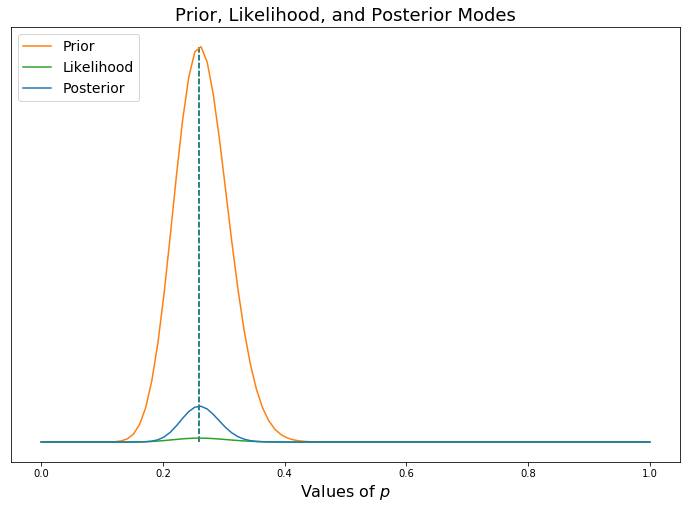

In [63]:
plot_beta_binomial(a = 27,
                   b = 75,
                   n_trials = 100,
                   n_successes = 26
)

### 3) Calculate the maximum a posteriori (MAP) estimate of players' batting averages.

The maximum a posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior beta distribution we get from updating our prior distribution with their at bats and hits.

---

> *Note: For an additional overview of the math behind updating the beta distribution posterior and conjugate priors, ([check out this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/)).*

We need to update our beta distribution’s prior belief about batting averages with a player's at-bat and hit information to get a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution, the update is just a matter of adding in our new observations to the alpha and beta parameters, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits+1, prior_misses+1)
    beta_posterior = Beta(prior_hits + n_hits + 1, prior_misses + n_misses + 1)
    
> **Note:** This process will also be useful in the context of A/B testing, which we’ll look at later on.

For each player, update the prior to the posterior distribution and calculate the mode of the distribution. The mode of a beta distribution is conveniently defined as:

### $$ \frac{\alpha - 1}{\alpha + \beta -2} $$

Which means we don't even need to use SciPy's beta distribution function. Just calculate the new alpha (hits) and beta (misses) for each player's posterior beta distribution and plug them into the formula above to get the MAP estimate of batting the average.

In [64]:
data.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


In [65]:
# a_post = hits + a_prior
# b_post = at_bat - hits + b_prior

# map_est = (hits + a_prior + 1) / (a_prior + at_bat + b_prior - 2)

# def get_map(row):
#     alpha_posterior = row.hits + alpha_prior
#     beta_posterior = row.at_bat - row.hits + beta_prior
#     return (alpha_posterior-1)/(alpha_posterior+beta_posterior-2)

# hits['MAP'] = hits.apply(get_map, axis=1)
alpha_prior = 27
beta_prior = 77


# def map_function(row):
#     alpha_posterior = row.hits + alpha_prior
#     beta_posterior = row.at_bat - row.hits + beta_prior
#     return (alpha_posterior - 1 ) /  ( beta_posterior + alpha_posterior - 2 )

def map_function(dataframe):
    return ( dataframe.hits + 26 ) / ( dataframe.at_bat + 75 )

In [66]:
data['map_est'] = data.apply(map_function, axis = 1)

In [67]:
data.head()

,name,hits,at_bat,average,map_est
0,Hank Aaron,3771,12364,0.304998,0.305250
1,Tommie Aaron,216,944,0.228814,0.237488
2,Andy Abad,2,21,0.095238,0.291667
3,John Abadie,11,49,0.224490,0.298387
4,Ed Abbaticchio,772,3044,0.253614,0.255851


### 4) Look up the top and bottom batters according to the MAP estimate.

In [68]:
data.sort_values('map_est', ascending = True).head(3)

,name,hits,at_bat,average,map_est
598,Bill Bergen,516,3028,0.170410,0.174670
4031,John Humphries,52,364,0.142857,0.177677
3113,Buck Gladmon,56,380,0.147368,0.180220


In [69]:
data.sort_values('map_est', ascending = False).head(3)

,name,hits,at_bat,average,map_est
6308,Dan O'Connor,12,26,0.461538,0.376238
7799,Vince Sherlock,12,26,0.461538,0.376238
4153,Ray Jansen,4,5,0.800000,0.375000


In [70]:
data.describe()

,hits,at_bat,average,map_est
count,9429.00000,9429.000000,9429.000000,9429.000000
mean,341.55605,1280.125040,0.224995,0.279549
std,550.01369,1956.563564,0.091421,0.034816
min,0.00000,1.000000,0.000000,0.174670
25%,8.00000,41.000000,0.200000,0.253897
50%,70.00000,306.000000,0.241803,0.274301
75%,438.00000,1719.000000,0.266667,0.304277
max,4256.00000,14053.000000,1.000000,0.376238


### 5) Plot the MLE batting average against the MAP batting average.

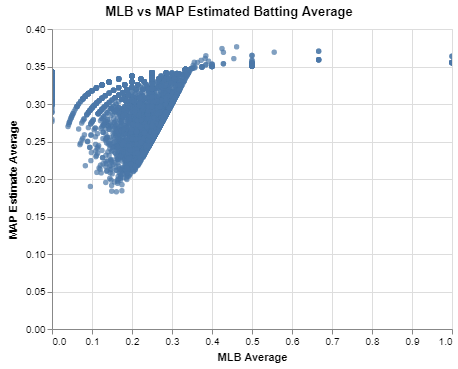

In [71]:
alt.Chart(data.sample(4999)).mark_circle().encode(
    alt.X('average', title = "MLB Average"),# scale = alt.Scale(domain=[-88.1, -87.3])),
    alt.Y('map_est', title = "MAP Estimate Average")#, scale = alt.Scale(domain=[41.6, 42.1])),
).properties(title= "MLB vs MAP Estimated Batting Average"
).interactive(
)